In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import pywt
from math import log2, ceil
from Data import SyntheticData
from Averages import Averages
import random
from matplotlib.ticker import ScalarFormatter, FixedFormatter, NullFormatter
import pandas as pd

In [3]:
np.random.seed(41)
n = 10000
data = SyntheticData(n = n, 
                     parameter_scale = 1, 
                     sample_mean = 0, 
                     sample_var = 1,
                     theta_type = 'hard_shift_2',
                     segment_size = 2000,
                     eta = 0.9,
                     decay_factor = 0.2
)
data.run()

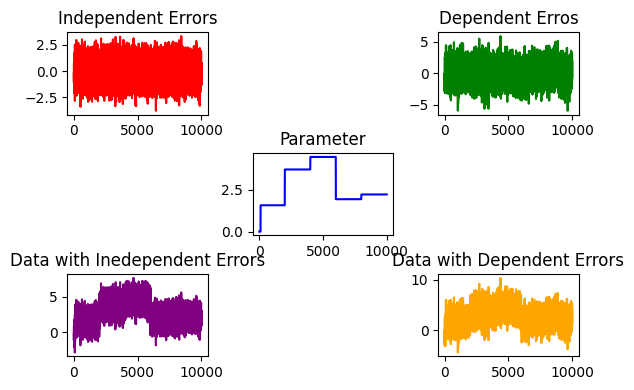

In [4]:
fig = plt.figure(figsize=(6, 4))
gs = fig.add_gridspec(3, 3, height_ratios=[1, 1, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 2])

ax3 = fig.add_subplot(gs[1, 1])

ax4 = fig.add_subplot(gs[2, 0])
ax5 = fig.add_subplot(gs[2, 2])


ax1.plot(range(n), data.norm_list, color = 'r')
ax1.set_title("Independent Errors")

ax2.plot(range(n), data.errors, color = 'g')
ax2.set_title("Dependent Erros")

ax3.plot(range(n), data.theta, color = 'b')
ax3.set_title("Parameter")

ax4.plot(range(n), data.ind, color = 'purple')
ax4.set_title("Data with Inedependent Errors")

ax5.plot(range(n), data.dep, color = 'orange')
ax5.set_title("Data with Dependent Errors")

# Adjust layout
plt.tight_layout()
plt.show()

In [5]:
class FLH:

    class _DefaultBlackBox:
        """
        An efficient O(1) implementation for calculating the running average.
        """
        def __init__(self):
            # Initialize sum and count for O(1) average calculation.
            self.sum_of_observations = 0.0
            self.num_observations = 0

        def predict(self) -> float:
            """
            Predicts the mean of observations in O(1) time.
            """
            if self.num_observations == 0:
                return 0.0
            
            return self.sum_of_observations / self.num_observations

        def observe(self, y: float):
            """
            Updates the running sum and count in O(1) time.
            """
            self.sum_of_observations += y
            self.num_observations += 1

    def __init__(self, alpha: float, black_box_class = None):
        if alpha <= 0:
            raise ValueError("Learning parameter alpha must be greater than 0.")
            
        self.alpha = alpha
        # Use the improved _DefaultBlackBox by default
        self.black_box_class = black_box_class if black_box_class else self._DefaultBlackBox
        
        self._reset()

    def _reset(self):
        self.t = 0
        self.v = {}  # Stores weights v_{t+1}^{(i)} for the next step
        self.v_hat_init = {}  # Stores initial weights \widehat{v}_t^{(t)}
        self.experts = []
        self.predictions = []
        self.y_history = []
        self.loss = []

    def run(self, y_sequence: list | np.ndarray, theta: list | np.ndarray) -> np.ndarray:
        """
        Runs the algorithm on a sequence of observations.

        Args:
            y_sequence (list or np.ndarray): The sequence of observed outcomes y_t.

        Returns:
            np.ndarray: The sequence of predictions widehat{mu}_t made by the algorithm.
        """
        self._reset()
        n = len(y_sequence)

        for t_idx in tqdm(range(n)):
            self.t += 1
            t = self.t
            y_t = y_sequence[t_idx]

            # At the start of time step t, we use weights v_t.
            # In our implementation, self.v stores v_t from the previous step.
            v_t = self.v.copy()
            
            # Step 1: Start new instance A_t (Line 4)
            v_t[t] = 1.0 / (t ** 2)
            self.v_hat_init[t] = 1.0 / (n)
            self.experts.append(self.black_box_class())

            # Step 2: Generate prediction (Lines 5-8)
            mu_hat_t = np.nan
            expert_predictions = {}
            
            # Predictions are only possible for t > 1
            if t > 1:
                # Get predictions from experts A_1, ..., A_{t-1} (Line 7)
                for i in range(1, t):
                    expert_predictions[i] = self.experts[i-1].predict()

                # Calculate prediction weights \widehat{v}_t^{(i)}
                v_hat_pred = {}
                
                # Weight for expert A_{t-1} (Line 6, second part)
                v_hat_pred[t-1] = self.v_hat_init[t-1]

                # Normalize weights for experts A_1, ..., A_{t-2} (Line 5)
                if t > 2:
                    # Sum of weights for "old" experts {1, ..., t-2}
                    sum_v_old = sum(v_t.get(j, 0) for j in range(1, t - 1))
                    
                    if sum_v_old > 1e-12: # Check for non-zero sum
                        norm_factor = (1.0 - 1.0 / (t - 1)) / sum_v_old
                        for i in range(1, t - 1):
                            v_hat_pred[i] = norm_factor * v_t.get(i, 0)
                    else: # Fallback for zero sum: uniform distribution
                        num_old_experts = t - 2
                        if num_old_experts > 0:
                            uniform_weight = (1.0 - 1.0 / ((t - 1) ** 2)) / num_old_experts
                            for i in range(1, t - 1):
                                v_hat_pred[i] = uniform_weight
                    self.v_hat_pred = v_hat_pred

                # Predict \widehat{\mu}_t (Line 8)
                mu_hat_t = sum(v_hat_pred.get(i, 0) * expert_predictions.get(i, 0) for i in range(1, t))
            
            self.predictions.append(mu_hat_t)
            self.y_history.append(y_t)

            # Step 3: All experts observe y_t
            # Experts A_1, ..., A_t have been created and observe y_t
            for expert in self.experts:
                expert.observe(y_t)

            # Step 4: Update weights for next step, v_{t+1} (Lines 10-12)
            v_next = {}
            # Update for expert t (Line 10)
            v_next[t] = v_t[t]

            # Update for experts 1, ..., t-1 (Line 12)
            loss = np.nan

            if t > 1:
                for i in range(1, t):
                    squared_loss = (y_t - expert_predictions[i])**2
                    v_next[i] = v_hat_pred.get(i, 0) * np.exp(-self.alpha * squared_loss)
                loss = (mu_hat_t - theta[t_idx]) ** 2
                
            # Store v_{t+1} for the next iteration
            self.v = v_next
            self.loss.append(loss)
            
            
        return np.array(self.predictions), np.array(self.loss)

In [17]:
class RollAverage:


    def __init__(self, lookback: int):
        if lookback <= 0:
            raise ValueError("Look back window parameter must be greater than 0.")
            
        self.lookback = lookback
        # Use the improved _DefaultBlackBox by default
        
        self._reset()

    def _reset(self):
        self.t = 0
        self.predictions = []
        self.y_history = []
        self.loss = []

    def run(self,
        y_sequence: list | np.ndarray, 
        theta: list | np.ndarray
    ) -> np.ndarray:

        self._reset()
        n = len(y_sequence)

        for t_idx in tqdm(range(n)):
            self.t += 1
            t = self.t
            y_t = y_sequence[t_idx]

            # Predictions are only possible for t > 1
            if t > 1:
                mu_hat_t = sum(self.y_history[-lookback:]) / len(self.y_history[-lookback:])
                self.predictions.append(mu_hat_t)
                
            self.y_history.append(y_t)

            loss = np.nan

            if t > 1:
                loss = (mu_hat_t - theta[t_idx]) ** 2

            self.loss.append(loss)
            
        return np.array(self.predictions), np.array(self.loss)

In [7]:
class IFLH:

    class _DefaultBlackBox:
        """
        An efficient O(1) implementation for calculating the running average.
        """
        def __init__(self):
            # Initialize sum and count for O(1) average calculation.
            self.sum_of_observations = 0.0
            self.num_observations = 0

        def predict(self) -> float:
            """
            Predicts the mean of observations in O(1) time.
            """
            if self.num_observations == 0:
                return 0.0
            
            return self.sum_of_observations / self.num_observations

        def observe(self, y: float):
            """
            Updates the running sum and count in O(1) time.
            """
            self.sum_of_observations += y
            self.num_observations += 1

    def __init__(self, alpha: float, K_base=2, black_box_class=None):
        if alpha <= 0:
            raise ValueError("Learning parameter alpha must be greater than 0.")
            
        self.alpha = alpha
        self.K = K_base
        # Use the improved _DefaultBlackBox by default
        self.black_box_class = black_box_class if black_box_class else self._DefaultBlackBox
        
        self._reset()

    def _reset(self):
        """Resets the internal state of the algorithm."""
        self.t = 0
        self.v = {}  # Stores weights v_{t+1}^{(i)} for the next step
        self.v_hat_init = {}  # Stores initial weights \widehat{v}_t^{(t)}
        self.tau = {} # Stores lifetime tau_i for each expert i
        self.experts = []
        self.predictions = []
        self.y_history = []
        self.len_experts = []
        self.loss = []

    def _calculate_tau(self, t: int) -> int:
        """
        Calculates tau_t = t + 2^k, where 2^k is the least significant bit of t.
        This can be computed efficiently using the bitwise operation: t + (t & -t).
        """
        if t == 0:
            return 1  # t = 0 has no 1s in binary; by convention we return 1
        
        # Find least significant bit (LSB) position that is set to 1
        k = (t & -t).bit_length() - 1  # Trick to find index of LSB 1
        result = t + 2 ** k
        return result
    
    def _calculate_tau_K(self, t: int) -> int:
        if t == 0:
            return self.K # Default for t=0

        beta = []
        temp_t = t
        while temp_t > 0:
            beta.append(temp_t % self.K)
            temp_t //= self.K
        
        # Find smallest k such that beta[k] > 0
        k = -1
        for i in range(len(beta)):
            if beta[i] > 0:
                k = i
                break
        
        if k == -1: # Should not happen if t > 0
            return self.K
        
        # Zero out beta[k]
        beta[k] = 0

        # Ensure beta has at least k+2 digits to accommodate K^{k+1}
        while len(beta) <= k + 1:
            beta.append(0)

        # Add 1 to beta[k+1]
        beta[k + 1] += 1

        # Handle carry-over if necessary
        for i in range(k + 1, len(beta)):
            if beta[i] >= self.K:
                beta[i] -= self.K
                if i + 1 >= len(beta):
                    beta.append(1)
                else:
                    beta[i + 1] += 1
            else:
                break

        # Convert back to integer from base-K
        result = sum(d * (self.K ** i) for i, d in enumerate(beta))
        return result

    def run(self, y_sequence: list | np.ndarray, theta: list | np.ndarray) -> np.ndarray:
        self._reset()
        n = len(y_sequence)

        for t_idx in tqdm(range(n)):
            self.t += 1
            t = self.t
            y_t = y_sequence[t_idx]

            # At the start of time step t, we use weights v_t.
            v_t = self.v.copy()
            
            # Step 1: Start new instance A_t and assign weights (Line 4)
            v_t[t] = 1.0 / t
            self.v_hat_init[t] = 1.0 / t
            self.experts.append(self.black_box_class())
            
            # Step 2: Define tau_t and the active expert set S_t (Lines 5-6)
            self.tau[t] = self._calculate_tau_K(t)
            active_experts_S_t = {i for i in range(1, t) if self.tau.get(i, 0) > t - 1}
            self.len_experts.append(len(active_experts_S_t))

            # Step 3: Generate prediction (Lines 7-10)
            mu_hat_t = np.nan
            expert_predictions = {}
            
            if t > 1 and active_experts_S_t:
                # Get predictions from active experts A_i, i in S_t (Line 9)
                for i in active_experts_S_t:
                    expert_predictions[i] = self.experts[i-1].predict()

                # Calculate prediction weights \widehat{v}_t^{(i)} for i in S_t
                v_hat_pred = {}
                sum_v_active = sum(v_t.get(j, 0) for j in active_experts_S_t)

                if sum_v_active > 1e-12:
                    for i in active_experts_S_t:
                        v_hat_pred[i] = v_t.get(i, 0) / sum_v_active
                else:  # Fallback for zero sum: uniform distribution
                    uniform_weight = 1.0 / len(active_experts_S_t)
                    for i in active_experts_S_t:
                        v_hat_pred[i] = uniform_weight
                
                # Predict \widehat{\mu}_t by summing over active experts S_t (Line 10)
                mu_hat_t = sum(v_hat_pred.get(i, 0) * expert_predictions.get(i, 0) for i in active_experts_S_t)

            self.predictions.append(mu_hat_t)
            self.y_history.append(y_t)

            # Step 4: All experts (1..t) observe y_t
            for expert in self.experts:
                expert.observe(y_t)

            # Step 5: Update weights for next step, v_{t+1} (Lines 12-13)
            v_next = {}
            # Set weight for the new expert t (Line 12)
            v_next[t] = v_t.get(t, 0)

            loss = np.nan
            if t > 1:
                # Update weights for active experts based on loss
                for i in active_experts_S_t:
                    squared_loss = (y_t - expert_predictions[i]) ** 2
                    v_next[i] = v_hat_pred.get(i, 0) * np.exp(-self.alpha * squared_loss)
                if not np.isnan(mu_hat_t):
                    loss = (mu_hat_t - theta[t_idx]) ** 2
            
            self.loss.append(loss)
            
            # Store v_{t+1} for the next iteration
            self.v = v_next
            
        return np.array(self.predictions), np.nancumsum(np.array(self.loss))}

In [75]:
class TFLH:

    def __init__(
        self, 
        m: int, 
        alpha: float, 
        black_box_class = None
    ):
        if m <= 0:
            raise ValueError("m must be positive")

        self.m = m
        self.alpha = alpha
        self.black_box_class = black_box_class

        
        self.streams = [
            FLH(alpha=alpha, black_box_class=black_box_class)
            for _ in range(m)
        ]

    def moving_average(self, a):
        b = []
        for i in range(len(a)):
            start = max(0, i - self.m)
            window = a[start:i+1]
            b.append(sum(window) / len(window))
        return b

    def run(self, y_sequence: np.ndarray, theta: np.ndarray):
        n = len(y_sequence)
        m = self.m

        stream_indices = [[] for _ in range(m)]
        for t in range(n):
            stream_indices[t % m].append(t)

        y_streams = [y_sequence[idxs] for idxs in stream_indices]
        theta_streams = [theta[idxs] for idxs in stream_indices]


        stream_preds = []
        stream_losses = []

        for k in range(m):
            preds_k, loss_k = self.streams[k].run(y_streams[k], theta_streams[k])
            stream_preds.append(preds_k)
            stream_losses.append(loss_k)

        preds = np.full(n, np.nan)
        losses = np.full(n, np.nan)

        for k in range(m):
            idxs = stream_indices[k]
            preds[idxs] = stream_preds[k]
            losses[idxs] = stream_losses[k]

        cum_loss = np.nancumsum(losses)

        avg_preds = self.moving_average(preds)

        return preds, avg_preds, cum_loss

In [76]:
class ARROWS:
    """
    A class-based implementation of the ARROWS algorithm for online change point detection.

    This class maintains the state of the algorithm, allowing it to be used for both
    batch processing of an entire dataset or for step-by-step online detection.

    Args:
        n (int): The total expected length of the time series (time horizon).
        sigma (float): The standard deviation of the noise.
        beta (float): The learning parameter, must be > 24.
    """

    def __init__(self, n: int, sigma: float, beta: float):
        if beta <= 24:
            raise ValueError("Parameter 'beta' must be greater than 24.")
        if n <= 0:
            raise ValueError("Time horizon 'n' must be positive.")

        self.n = n
        self.sigma = sigma
        self.beta = beta

        # Pre-calculate the threshold tau for efficiency
        self.tau = self.sigma * np.sqrt(self.beta * np.log(self.n))

        # Initialize the algorithm's state
        self.reset()

    def reset(self):
        """Resets the algorithm's state to its initial values."""
        self.t_B = 0  # Start time of the current bin (0-based index)
        self.Bin = 1  # Flag: 1 if a new bin just started, 0 otherwise
        self.y_prev = np.nan  # Previous observation y_{t-1}
        self.y_history = [] # Stores all observed y so far

        # Results
        self.detected_cps = []
        self.predictions = []
        self.total_loss = 0
        self.current_time = 0

    @staticmethod
    def _soft_threshold(x, threshold):
        """Performs element-wise soft thresholding on a numpy array."""
        return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

    def _run_detection_test(self):
        """
        Performs the core change point detection test for the current window.
        
        Returns:
            bool: True if a change point is detected, False otherwise.
        """
        window_data = np.array(self.y_history[self.t_B:])
        window_len = len(window_data)

        if window_len <= 1:
            return False

        # Pad the window to the next power of 2 (k) for the wavelet transform
        k = 1 << (window_len - 1).bit_length()
        
        # Create the zero-padded, mean-centered vector y_tilde
        win_mean = np.mean(window_data)
        y_tilde_unpadded = window_data - win_mean
        y_tilde = np.pad(y_tilde_unpadded, (0, k - window_len), 'constant')

        # Wavelet transform requires at least 2 points
        max_level = int(np.log2(k))
        if max_level < 1:
            return False

        # H * y_tilde: Perform the discrete wavelet transform
        coeffs = pywt.wavedec(y_tilde, 'haar', level=max_level)
        
        # T(H * y_tilde): Apply soft thresholding to all coefficients
        thresholded_coeffs = [ARROWS._soft_threshold(c, self.tau) for c in coeffs]
        
        # Calculate the test statistic
        test_statistic = 0
        detail_coeffs_thresh = thresholded_coeffs[1:]
        
        for l, cD_thresh in enumerate(detail_coeffs_thresh):
            test_statistic += (2**(l / 2)) * np.linalg.norm(cD_thresh, ord=1)
        
        return test_statistic / np.sqrt(len(thresholded_coeffs)) > self.sigma / np.sqrt(self.n)

    def process_step(self, y_t: float):
        """
        Processes a single data point y_t, updates the state, and runs the test.

        Args:
            y_t (float): The new data point observed at the current time step.
        """
        if self.Bin == 1:
            prediction = self.y_prev
        else:
            prediction = np.mean(self.y_history[self.t_B:])
        
        self.predictions.append(prediction)


        self.total_loss += (prediction - y_t)**2
        self.y_history.append(y_t)
        self.y_prev = y_t
        self.Bin = 0

        if self._run_detection_test():
            self.Bin = 1
            self.t_B = self.current_time + 1
            self.detected_cps.append(self.t_B)

        self.current_time += 1

    def run(self, y: np.ndarray, theta: np.ndarray):
        """
        Runs the ARROWS algorithm on an entire dataset and returns the predictions.

        Args:
            y (np.ndarray): The full time series data.

        Returns:
            np.ndarray: An array containing the sequence of predictions.
        """
        if len(y) != self.n:
            raise ValueError(f"Input data length {len(y)} does not match "
                             f"the expected time horizon n={self.n}")
        
        self.reset()
        for y_t in tqdm(y):
            self.process_step(y_t)

        predictions_arr = np.array(self.predictions)
        
        # Calculate the loss between prediction and the true parameter theta
        loss_vs_theta = (predictions_arr - theta)**2
        
        # Calculate the cumulative sum, treating the initial nan as zero in the sum
        cumulative_loss_vs_theta = np.nancumsum(loss_vs_theta)
            
        return np.array(self.predictions), cumulative_loss_vs_theta

In [77]:
n = 10000
segment_size = 2000

type_signal = 'hard'

if type_signal == 'hard':
    theta_type = 'hard_shift'
elif type_signal == 'hard_2':
    theta_type = 'hard_shift_2'
else:
    theta_type = 'soft_shift'


np.random.seed(42)
data = SyntheticData(
    n = n, 
    parameter_scale = 1, 
    sample_mean = 0, 
    sample_var = 1,
    theta_type = theta_type,
    segment_size = segment_size
)
data.run()

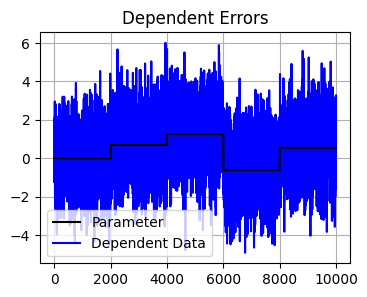

In [78]:
ind_data = False
fig, ax = plt.subplots(figsize = (4,3))

if ind_data:
    ax.plot(data.theta, color = 'k', label = 'Parameter', zorder = 10)
    ax.plot(data.ind, color = 'red', label = 'Independent Data', zorder = 5)
    ax.set_title('Independent Errors')

else:
    ax.plot(data.theta, color = 'k', label = 'Parameter', zorder = 10)
    ax.plot(data.dep, color = 'blue', label = 'Dependent Data', zorder = 5)
    ax.set_title('Dependent Errors')

ax.grid()
ax.legend()
plt.show()

In [79]:
#alpha_lst = [1, 0.1, 0.05, 0.01, 0.001, 0.0001]
#alpha_lst = [0.05]
#M = int(np.log(n))
#results_flh = {}
#results_flht = {}
#for i in alpha_lst:
#    thinned_flh_runner_temp = ThinnedFLH(m=M, alpha=i)
#    flh_temp = FLH(alpha = i)

#    _, loss_dep_temp = flh_temp.run(y_data_dep, theta)
#    loss_dep_temp = np.nancumsum(loss_dep_temp)

#    _, cumulative_loss_tempt = thinned_flh_runner_temp.run(y_data_dep, theta)

#    final_loss = cumulative_loss_tempt[~np.isnan(loss_dep_temp)][-1]
#    final_loss_t = cumulative_loss_tempt[~np.isnan(cumulative_loss_tempt)][-1]

#    results_flh[i] = final_loss
#    results_flht[i] = final_loss_t

#best_alpha = min(results_flh, key=results_flh.get)
#best_alphat = min(results_flht, key=results_flht.get)
#print('FLH', best_alpha, 'FLH_T', best_alphat)

In [80]:
SIGMA = np.sqrt(1)   # Standard deviation of the noise
BETA = 24+1e-10    # ARROWS parameter (must be > 24)
ALPHA = 0.5/(np.log(n) ** 1)
ALPHA_T = 1/(np.log(n) ** 1) # Learning rate for FLH
lookback = 100 #lookback

gamma = 1.1 #\gamma > 1
M = int(np.log(n) ** gamma) # Number of bins for data thinning

y_data_dep = data.dep
y_data_ind = data.ind
theta = data.theta

flh_algorithm = IFLH(alpha=ALPHA)
pred_dep, loss_dep = flh_algorithm.run(y_data_dep, theta)
#pred_ind, loss_ind = flh_algorithm.run(y_data_ind, theta)
loss_dep = np.nancumsum(loss_dep)
#loss_ind = np.nancumsum(loss_ind)

thinned_flh_runner = TFLH(m=M, alpha=ALPHA_T)
predt_dep, predt_avg_dep, losst_dep = thinned_flh_runner.run(y_data_dep, theta)
#predt_ind, predt_avg_ind, losst_ind = thinned_flh_runner.run(y_data_ind, theta)

arrows_detector = ARROWS(n=n, sigma=SIGMA, beta=BETA)
preda_dep, lossa_dep = arrows_detector.run(y_data_dep, theta)
#preda_ind, lossa_ind = arrows_detector.run(y_data_ind, theta)

rolling_average = RollAverage(lookback = lookback)
pred_dep_roll, loss_dep_roll = rolling_average.run(y_data_dep, theta)
pred_ind_roll, loss_ind_roll = rolling_average.run(y_data_ind, theta)
loss_dep_roll, loss_ind_roll = np.nancumsum(loss_dep_roll), np.nancumsum(loss_ind_roll)


100%|██████████| 10000/10000 [00:00<00:00, 205740.30it/s]


In [73]:
np.log(n) ** 1.5
n, np.log(n) ** 1.1

(10000, np.float64(11.500143194698913))

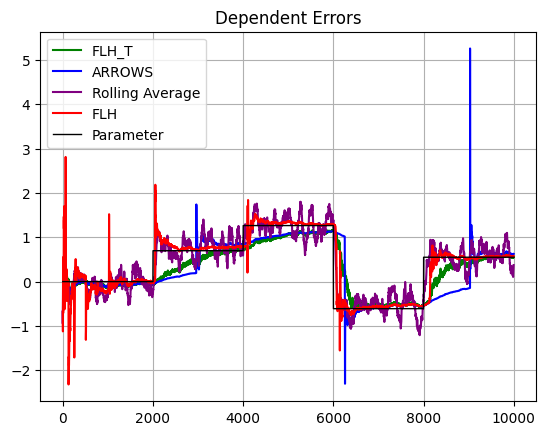

In [82]:
flh_c, flht_c, arrows_c, roll_c = True, True, True, True
theta_c, error_c = True, False
ind, dep = False, True

x = 0
y = n

fig, ax = plt.subplots()



if error_c:
    if ind:
        ax.plot(y_data_ind[x:y], color = 'c', label = 'Ground Truth')
    if dep:
        ax.plot(y_data_dep[x:y], color = 'c', label = 'Ground Truth')




if flht_c:
    if ind:
        ax.plot(predt_avg_ind[x:y], color = 'g', label = 'FLH_T')
    if dep:
        ax.plot(predt_avg_dep[x:y], color = 'g', label = 'FLH_T')
        
if arrows_c:
    if ind:
        ax.plot(preda_ind[x:y], color = 'b', label = 'ARROWS')
    if dep:
        ax.plot(preda_dep[x:y], color = 'b', label = 'ARROWS')

if roll_c:
    if ind:
        ax.plot(pred_ind_roll[x:y], color = 'purple', label = 'Rolling Average')
    if dep:
        ax.plot(pred_dep_roll[x:y], color = 'purple', label = 'Rolling Average')

if flh_c:
    if ind:
        ax.plot(pred_ind[x:y], color = 'r', label = 'FLH')
    if dep:
        ax.plot(pred_dep[x:y], color = 'r', label = 'FLH')

if theta_c:
    if ind:
        ax.plot(theta[x:y], color = 'k', label = 'Parameter', linewidth = 1)
    if dep:
        ax.plot(theta[x:y], color = 'k', label = 'Parameter', linewidth = 1)

if ind:
    ax.set_title("Independent Errors")
if dep:
    ax.set_title("Dependent Errors")

ax.legend()
ax.grid()

plt.show()

In [67]:
np.log(10000)

np.float64(9.210340371976184)

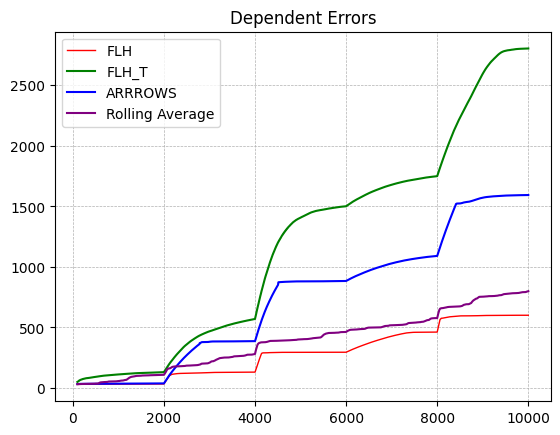

In [381]:
check_flh, check_tflh, check_arrows = True, True, True
check_ind, check_dep = False, True
check_optimal = False
check_roll = True

start_index = 100
x_values = np.arange(start_index, n)

fig, ax = plt.subplots()

if check_flh:
    if check_dep:
        ax.plot(x_values, loss_dep[start_index:], color = 'r', label = 'FLH', linewidth = 1)
    if check_ind:
        ax.plot(x_values, loss_ind[start_index:], color = 'r', label = 'FLH', linewidth = 1)
if check_tflh:
    if check_dep:
        ax.plot(x_values, losst_dep[start_index:], color = 'g', label = 'FLH_T')
    if check_ind:
        ax.plot(x_values, losst_ind[start_index:], color = 'g', label = 'FLH_T')
if check_arrows:
    if check_dep:
        ax.plot(x_values, lossa_dep[start_index:], color = 'b', label = 'ARRROWS')
    if check_ind:
        ax.plot(x_values, lossa_ind[start_index:], color = 'b', label = 'ARRROWS')
if check_roll:
    if check_dep:
        ax.plot(x_values, loss_dep_roll[start_index:], color = 'purple', label = "Rolling Average")
    if check_ind:
        ax.plot(x_values, loss_ind_roll[start_index:], color = 'purple', label = "Rolling Average")
if check_optimal:
    ax.plot(x_values, (100*data.bound)[start_index:], color = 'k', label = r'$C_n^{2/3}n^{1/3}$', linestyle = 'dashed')

#ax.set_xscale('log')
#ax.set_yscale('log')

#powers = np.arange(2.0, 3.01, 0.2)  
#x_tick_locations = 10**powers
#x_tick_labels = [f"$10^{{{p:.1f}}}$" for p in powers]
#ax.set_xticks(x_tick_locations)
#ax.set_xticklabels(x_tick_labels)
#ax.xaxis.set_major_formatter(FixedFormatter(x_tick_labels))
#ax.tick_params(axis='x')
#ax.xaxis.set_minor_formatter(NullFormatter())
#ax.set_xlim(10**2-10, 10**3)

#y_tick_locations = [100, 500, 1000, 2000] # Example y-values
#ax.set_yticks(y_tick_locations)
#ax.set_yticklabels(y_tick_locations)

#ax.get_yaxis().set_major_formatter(ScalarFormatter())

ax.grid(True, which="major", linestyle='--', linewidth=0.5)
ax.legend()
if check_ind:
    ax.set_title("Independent Errors")
if check_dep:
    ax.set_title("Dependent Errors")
plt.show()

In [16]:
flh_algorithm.v_hat_pred[8600], flh_algorithm_1.v_hat_pred[8600]

(np.float64(1.775892617017036e-09), np.float64(1.775892617017036e-09))

In [18]:
total = sum(x - y for x, y in zip(flh_algorithm.v_hat_pred, flh_algorithm_1.v_hat_pred))
total

0

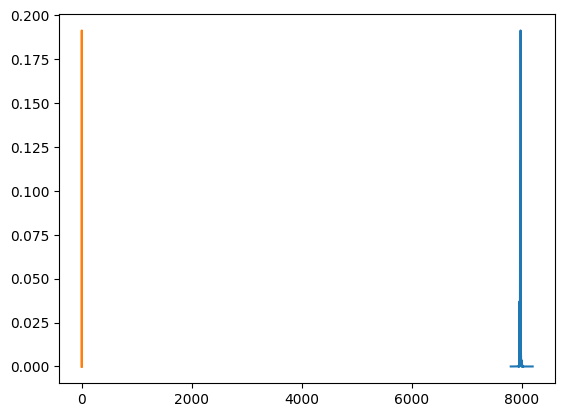

In [370]:
plt.plot(list(flh_algorithm.v_hat_pred.items()), list(flh_algorithm.v_hat_pred.values()))
plt.show()

In [303]:
type_signal_temp = True
avg_num = 5
n = 1000

loss_dep_sum, loss_ind_sum = np.zeros(n), np.zeros(n)
losst_dep_sum, losst_ind_sum = np.zeros(n), np.zeros(n)
lossa_dep_sum, lossa_ind_sum = np.zeros(n), np.zeros(n)
bound_sum = np.zeros(n)

for i in range(avg_num):
    if type_signal_temp:
        data_temp = SyntheticData(n = n, 
                            parameter_scale = 1, 
                            sample_mean = 0, 
                            sample_var = 1,
                            theta_type = 'hard_shift_2',
                            segment_size = 200,
                            decay_factor = 0.6
        )
    else:
        data_temp = SyntheticData(n = n, 
                            parameter_scale = 1, 
                            sample_mean = 0, 
                            sample_var = 1,
                            theta_type = 'soft_shift',
                            segment_size = 200
        )

    data_temp.run()

    SIGMA = np.sqrt(1)   # Standard deviation of the noise
    BETA = 25.1    # ARROWS parameter (must be > 24)
    ALPHA = 0.1
    ALPHA_T = 0.1 # Learning rate for FLH

    M = int(np.log(n))     # Number of bins for data thinning

    y_data_dep_temp = data_temp.dep
    y_data_ind_temp = data_temp.ind
    theta_temp = data_temp.theta

    flh_algorithm_temp = FLH(alpha=ALPHA)
    pred_dep_temp, loss_dep_temp = flh_algorithm_temp.run(y_data_dep_temp, theta_temp)
    pred_ind_temp, loss_ind_temp = flh_algorithm_temp.run(y_data_ind_temp, theta_temp)
    loss_dep_temp, loss_ind_temp = np.nancumsum(loss_dep_temp), np.nancumsum(loss_ind_temp)

    thinned_flh_runner_temp = ThinnedFLH(m=M, alpha=ALPHA_T)
    predt_dep_temp, losst_dep_temp = thinned_flh_runner_temp.run(y_data_dep_temp, theta_temp)
    predt_ind_temp, losst_ind_temp = thinned_flh_runner_temp.run(y_data_ind_temp, theta_temp)

    arrows_detector_temp = ARROWS(n=n, sigma=SIGMA, beta=BETA)
    preda_dep_temp, lossa_dep_temp = arrows_detector_temp.run(y_data_dep_temp, theta_temp)
    preda_ind_temp, lossa_ind_temp = arrows_detector_temp.run(y_data_ind_temp, theta_temp)
    
    loss_dep_sum += loss_dep_temp
    loss_ind_sum += loss_ind_temp
    losst_dep_sum += losst_dep_temp
    losst_ind_sum += losst_ind_temp
    lossa_dep_sum += lossa_dep_temp
    lossa_ind_sum += lossa_ind_temp
    bound_sum += data_temp.bound

loss_dep_sum = loss_dep_sum / len(range(avg_num))
loss_ind_sum = loss_ind_sum / len(range(avg_num))
losst_dep_sum = losst_dep_sum / len(range(avg_num))
losst_ind_sum = losst_ind_sum / len(range(avg_num))
lossa_dep_sum = lossa_dep_sum / len(range(avg_num))
lossa_ind_sum = lossa_ind_sum / len(range(avg_num))
bound_sum = bound_sum / len(range(avg_num))

100%|██████████| 1000/1000 [00:00<00:00, 10965.87it/s]


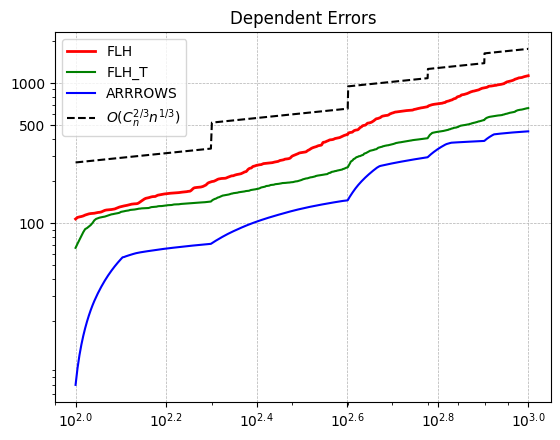

In [146]:
check_flh, check_tflh, check_arrows = True, True, True
check_dep = True
check_optimal = True

start_index = 100
x_values = np.arange(start_index, n)

fig, ax = plt.subplots()

if check_flh:
    if check_dep:
        ax.plot(x_values, loss_dep_sum[start_index:], color = 'r', label = 'FLH', linewidth = 2)
    else:
        ax.plot(x_values, loss_ind_sum[start_index:], color = 'r', label = 'FLH', linewidth = 1)
if check_tflh:
    if check_dep:
        ax.plot(x_values, losst_dep_sum[start_index:], color = 'g', label = 'FLH_T')
    else:
        ax.plot(x_values, losst_ind_sum[start_index:], color = 'g', label = 'FLH_T')
if check_arrows:
    if check_dep:
        ax.plot(x_values, lossa_dep_sum[start_index:]/ 2, color = 'b', label = 'ARRROWS')
    else:
        ax.plot(x_values, lossa_ind_sum[start_index:]/ 2, color = 'b', label = 'ARRROWS')
if check_optimal:
    ax.plot(x_values, (50*bound_sum)[start_index:], color = 'k', label = r'$O(C_n^{2/3}n^{1/3})$', linestyle = 'dashed')

ax.set_xscale('log')
ax.set_yscale('log')

powers = np.arange(2.0, 3.01, 0.2)  
x_tick_locations = 10**powers
x_tick_labels = [f"$10^{{{p:.1f}}}$" for p in powers]
ax.set_xticks(x_tick_locations)
ax.set_xticklabels(x_tick_labels)
ax.xaxis.set_major_formatter(FixedFormatter(x_tick_labels))
ax.tick_params(axis='x')
ax.xaxis.set_minor_formatter(NullFormatter())
ax.set_xlim(10**2-10, )

y_tick_locations = [100, 500, 1000] # Example y-values
ax.set_yticks(y_tick_locations)
ax.set_yticklabels(y_tick_locations)

ax.get_yaxis().set_major_formatter(ScalarFormatter())

ax.grid(True, which="major", linestyle='--', linewidth=0.5)
ax.legend()
if check_dep:
    ax.set_title("Dependent Errors")
else:
    ax.set_title("Independent Errors")
plt.show()

In [34]:
np.random.seed(43)
n_100 = 140
data_100 = SyntheticData(n = n_100, 
                     parameter_scale = 4, 
                     sample_mean = 0, 
                     sample_var = 1,
                     theta_type = 'hard_shift_2',
                     segment_size = 100,
                     eta = 1,
                     decay_factor = 0.2
)
data_100.run()

In [35]:
y_data_100_dep = data_100.dep
y_data_100_ind = data_100.ind
theta_100 = data_100.theta

flh_algorithm_100 = FLH(alpha=0.2)
pred_dep_100, loss_dep_100 = flh_algorithm_100.run(y_data_100_dep, theta_100)
pred_ind_100, loss_ind_100 = flh_algorithm_100.run(y_data_100_ind, theta_100)
loss_dep_100, loss_ind_100 = np.nancumsum(loss_dep_100), np.nancumsum(loss_ind_100)

100%|██████████| 140/140 [00:00<00:00, 12941.39it/s]


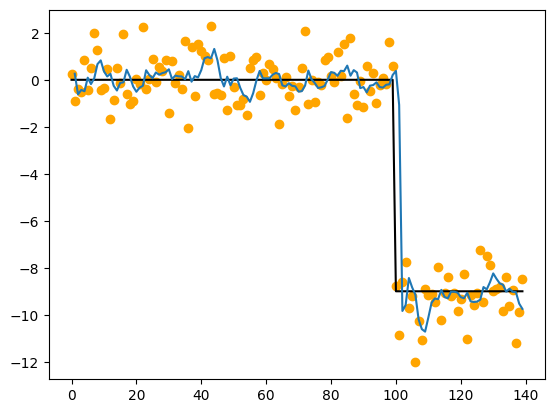

In [36]:
plt.scatter(range(n_100), data_100.ind, color = 'orange')
plt.plot(data_100.theta, color = 'k')
plt.plot(pred_ind_100)
plt.show()

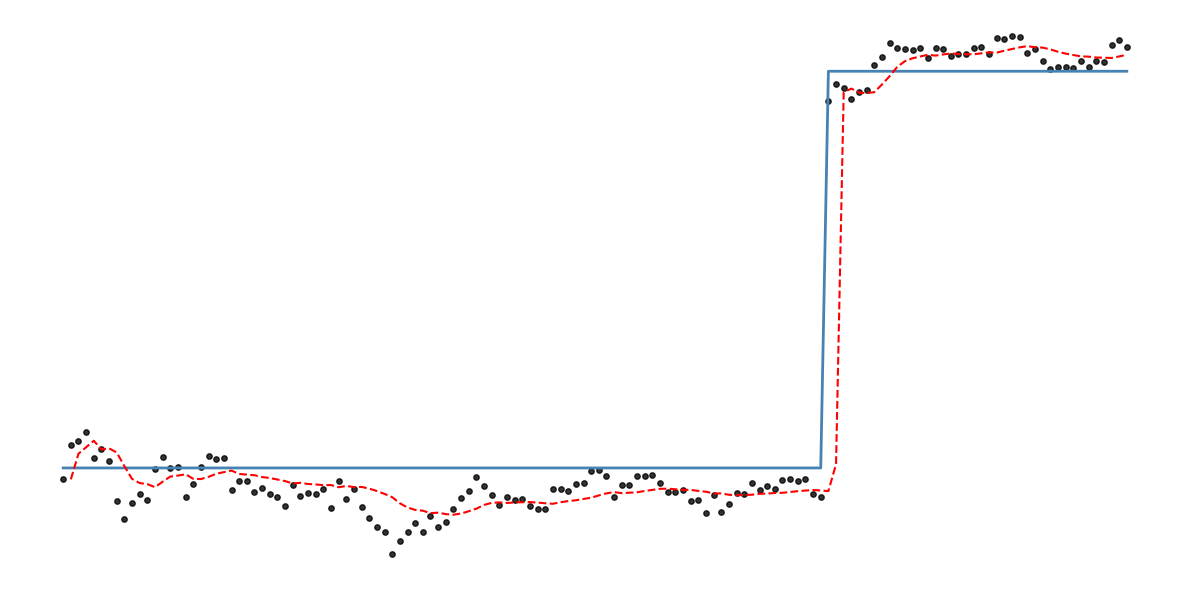

In [37]:
# 1. Create a figure and axes for better control
fig, ax = plt.subplots(figsize=(12, 6))

# 2. Set a background color (optional, but looks good on slides)
# A dark background makes colors pop.
# fig.set_facecolor('#2B2B2B')
ax.set_facecolor('#2B2B2B')

# 3. Apply your plotting commands with aesthetic styles
# Scatter plot: use alpha for a softer look and 's' for size
ax.scatter(range(n_100), (-1)* data_100.dep, color='k', s=15, alpha=0.8) # Gold color, smaller size

# First plot: A smooth, prominent line
ax.plot((-1) * data_100.theta, color='#4682B4', linewidth=2) # Steel Blue color

# Second plot: A dashed line to differentiate it
ax.plot((-1) * pred_dep_100, color='red', linestyle='--', linewidth=1.5) # Light Salmon color

# 4. Turn off all axes and borders for a clean, title-page look
ax.axis('off')

# 5. Ensure a clean layout
plt.tight_layout()

# Show the final plot
plt.show()

In [38]:
df = pd.read_csv("Colorado_River.csv")
df['dateTime'] = pd.to_datetime(df['dateTime'], errors='coerce')
df.dropna(subset=['dateTime'], inplace=True)
df_1 = df.groupby(df['dateTime'].dt.date)['X_00065_00000'].mean()
df_1 = df_1.reset_index(name='water_level')

In [39]:
df_3 = df_1.tail(32).reset_index()

In [40]:
alg_river = FLH(alpha = 0.1)
data_river = np.array(df_3["water_level"])
df_3['pred'], loss_river = alg_river.run(data_river, data_river)

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:00<00:00, 52103.16it/s]


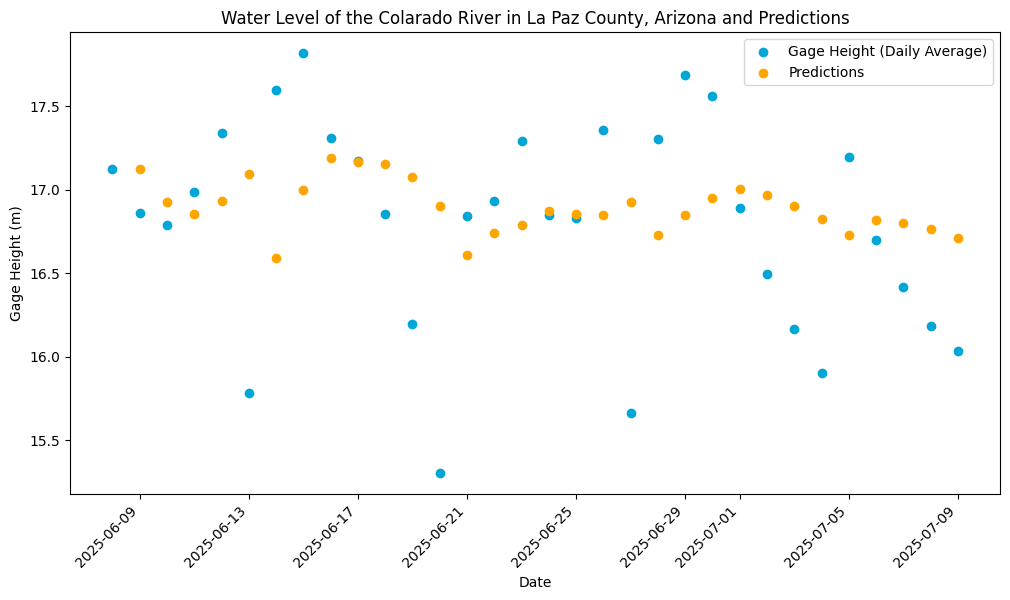

In [41]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.grid(False)

ax.scatter(df_3['dateTime'], df_3['water_level'], label = 'Gage Height (Daily Average)', color = '#00A6D6')
ax.scatter(df_3['dateTime'], df_3['pred'], label = 'Predictions', color = 'orange')
plt.xlabel('Date')
plt.ylabel('Gage Height (m)')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.title('Water Level of the Colarado River in La Paz County, Arizona and Predictions')
plt.show()

In [42]:
er = np.random.normal(loc = 0, scale = 1, size = 30)

In [43]:
a = [1, 1, 1, 1, 1]
b = [1.1, 1.2, 1.3, 1.5, 1.7, 2, 2.3, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4]
a = np.array(a + a + a + b)
a = 10*a + er

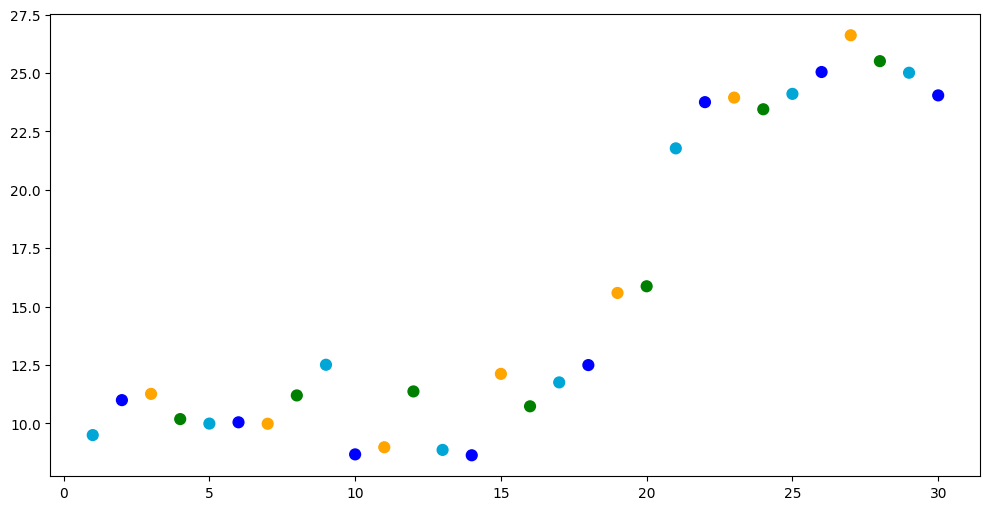

In [44]:
color_sequence = ['#00A6D6', 'blue', 'orange', 'green']
num_colors = len(color_sequence)

point_colors = [color_sequence[i % num_colors] for i in range(30)]

fig, ax = plt.subplots(figsize=(12, 6))
plt.grid(False)

ax.scatter(range(1, 31), a, color = point_colors, s=60)
plt.show()

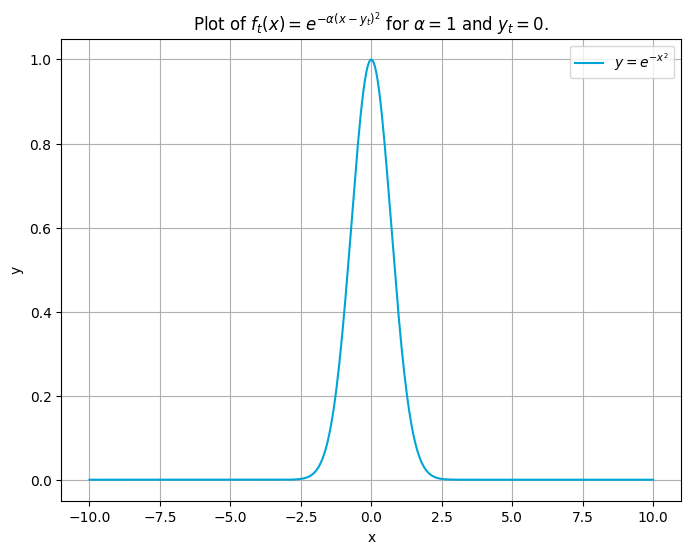

In [45]:
# Define the x-axis data
x = np.linspace(-10, 10, 400)

# Calculate the corresponding y-values
y = np.exp(-(x)**2)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(x, y, label=r'$y = e^{-x^2}$', color = '#00A6D6')
plt.title(r'Plot of $f_t(x) = e^{-\alpha(x-y_t)^2}$ for $\alpha=1$ and $y_t=0$.')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.show()